In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib

import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
df = pd.read_csv('no_show_original_data_2016.csv') #df = the original data from Kaggle
df_w_weather = pd.read_csv('no_show_github_with_weather_dec_16_1113.csv') #df_w_weather = with weather from github
df_w_data = pd.read_csv('brazil_history_export_2018-12-16T13_41_43.csv') #brazil historical weather data only

In [13]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [14]:
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [23]:
df['PatientId'].value_counts().head()

8.221459e+14    88
9.963767e+10    84
2.688613e+13    70
3.353478e+13    65
2.584244e+11    62
Name: PatientId, dtype: int64

In [24]:
df['AppointmentID'].value_counts().head()

5769215    1
5731652    1
5707080    1
5702986    1
5715276    1
Name: AppointmentID, dtype: int64

In [28]:
df['SMS_received'].value_counts().head()

0    75044
1    35482
Name: SMS_received, dtype: int64

In [27]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105260e+05,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,5.675304e+06,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029
std,2.560943e+14,7.129544e+04,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874
min,3.920000e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172538e+12,5.640285e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173180e+13,5.680572e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.438960e+13,5.725523e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999820e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


### Analizing the date: first conclutions
1. There was 1 row with the age of (-1). It wasn't a no show, so I deleted it (Itamar).
2. The SMS column states if a text was sent or not. It does not state how many sms were sent.
3. Columns we need to add:

a) weather (many columns with different kind of data)

b) day of the week

c) holiday (y/n)


In [16]:
df.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [48]:
df_w_data()

,LAT;;;;;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584;47.5584
count,72
unique,72
top,2016;06;20;00;00;16.45;71.21;0.00;0.00;59.45;2...
freq,1


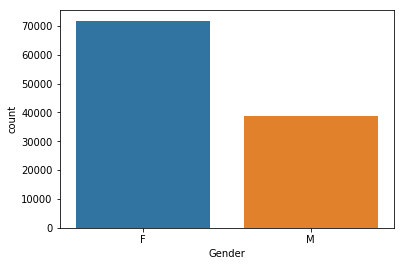

In [29]:
sns.countplot(x='Gender', data=df)

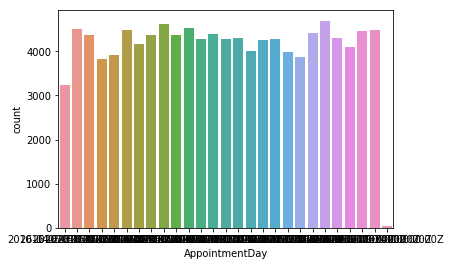

In [33]:
sns.countplot(x='AppointmentDay', data=df)

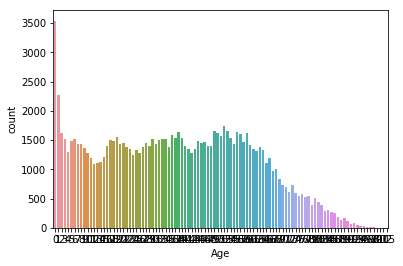

In [30]:
sns.countplot(x='Age', data=df)

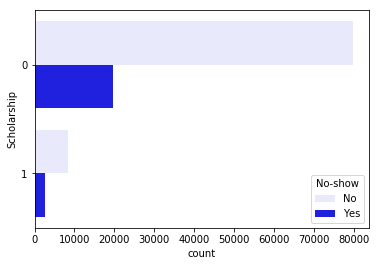

In [31]:
sns.countplot(y='Scholarship', data=df, color='blue',hue = 'No-show')

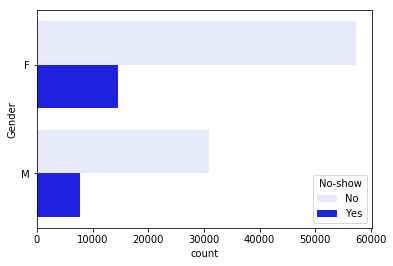

In [32]:
sns.countplot(y='Gender', data=df, color='blue',hue = 'No-show')

In [38]:
df.sort_values('AppointmentDay')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,7.184430e+13,5638545,F,2016-04-29T08:08:43Z,2016-04-29T00:00:00Z,0,CONQUISTA,0,0,0,0,0,0,No
69048,2.679540e+13,5639131,F,2016-04-29T08:44:51Z,2016-04-29T00:00:00Z,47,JARDIM CAMBURI,1,0,0,0,0,0,No
69049,1.327750e+14,5527925,F,2016-03-30T14:22:37Z,2016-04-29T00:00:00Z,47,CENTRO,0,0,0,0,0,1,No
69050,3.176230e+13,5634183,M,2016-04-28T10:30:55Z,2016-04-29T00:00:00Z,47,DA PENHA,0,1,0,0,0,0,No
69051,7.377490e+13,5634120,M,2016-04-28T10:25:55Z,2016-04-29T00:00:00Z,47,ENSEADA DO SUÁ,0,0,0,0,1,0,No
69052,9.182180e+11,5637498,M,2016-04-29T07:02:55Z,2016-04-29T00:00:00Z,47,FONTE GRANDE,0,1,1,0,0,0,No
69053,7.683140e+14,5589857,M,2016-04-15T13:03:11Z,2016-04-29T00:00:00Z,47,CENTRO,0,0,0,0,0,1,No
69054,1.686120e+11,5542224,M,2016-04-05T08:45:18Z,2016-04-29T00:00:00Z,47,JARDIM DA PENHA,0,0,0,0,0,0,No
69055,4.915400e+13,5562260,F,2016-04-08T13:05:27Z,2016-04-29T00:00:00Z,47,CENTRO,0,0,0,0,0,1,No
69056,8.268430e+13,5387260,M,2016-02-24T07:34:49Z,2016-04-29T00:00:00Z,47,SANTOS DUMONT,0,1,0,0,0,1,No


In [45]:
df['AppointmentDay'].value_counts()

2016-06-06T00:00:00Z    4691
2016-05-16T00:00:00Z    4613
2016-05-09T00:00:00Z    4520
2016-05-30T00:00:00Z    4514
2016-06-08T00:00:00Z    4479
2016-05-11T00:00:00Z    4474
2016-06-01T00:00:00Z    4464
2016-06-07T00:00:00Z    4416
2016-05-12T00:00:00Z    4394
2016-05-02T00:00:00Z    4376
2016-05-18T00:00:00Z    4373
2016-05-17T00:00:00Z    4372
2016-06-02T00:00:00Z    4310
2016-05-10T00:00:00Z    4308
2016-05-31T00:00:00Z    4279
2016-05-05T00:00:00Z    4273
2016-05-19T00:00:00Z    4270
2016-05-03T00:00:00Z    4256
2016-05-04T00:00:00Z    4168
2016-06-03T00:00:00Z    4090
2016-05-24T00:00:00Z    4009
2016-05-13T00:00:00Z    3987
2016-05-25T00:00:00Z    3909
2016-05-06T00:00:00Z    3879
2016-05-20T00:00:00Z    3828
2016-04-29T00:00:00Z    3235
2016-05-14T00:00:00Z      39
Name: AppointmentDay, dtype: int64